In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import geopandas as gpd
import palettable as pltt
import seaborn as sns
from seaborn import palplot
from shapely.geometry import Point
import pandas as pd
import numpy as np

In [2]:
lsoas_london_link = "../../London_Data/ESRI/LSOA_2011_London_gen_MHW.shp" 
lsoas_london = gpd.read_file(lsoas_london_link)
#keeping only some columns
lsoas_london = lsoas_london[['LSOA11CD','geometry']]
lsoas_london.head()

LSOA11CD                                           geometry
0  E01000001  POLYGON ((532105.0919998939 182011.23, 532162....
1  E01000002  POLYGON ((532746.8130000263 181786.891000028, ...
2  E01000003  POLYGON ((532135.1449999654 182198.1190000199,...
3  E01000005  POLYGON ((533807.9460001207 180767.7700000888,...
4  E01000006  POLYGON ((545122.048999952 184314.931000118, 5...

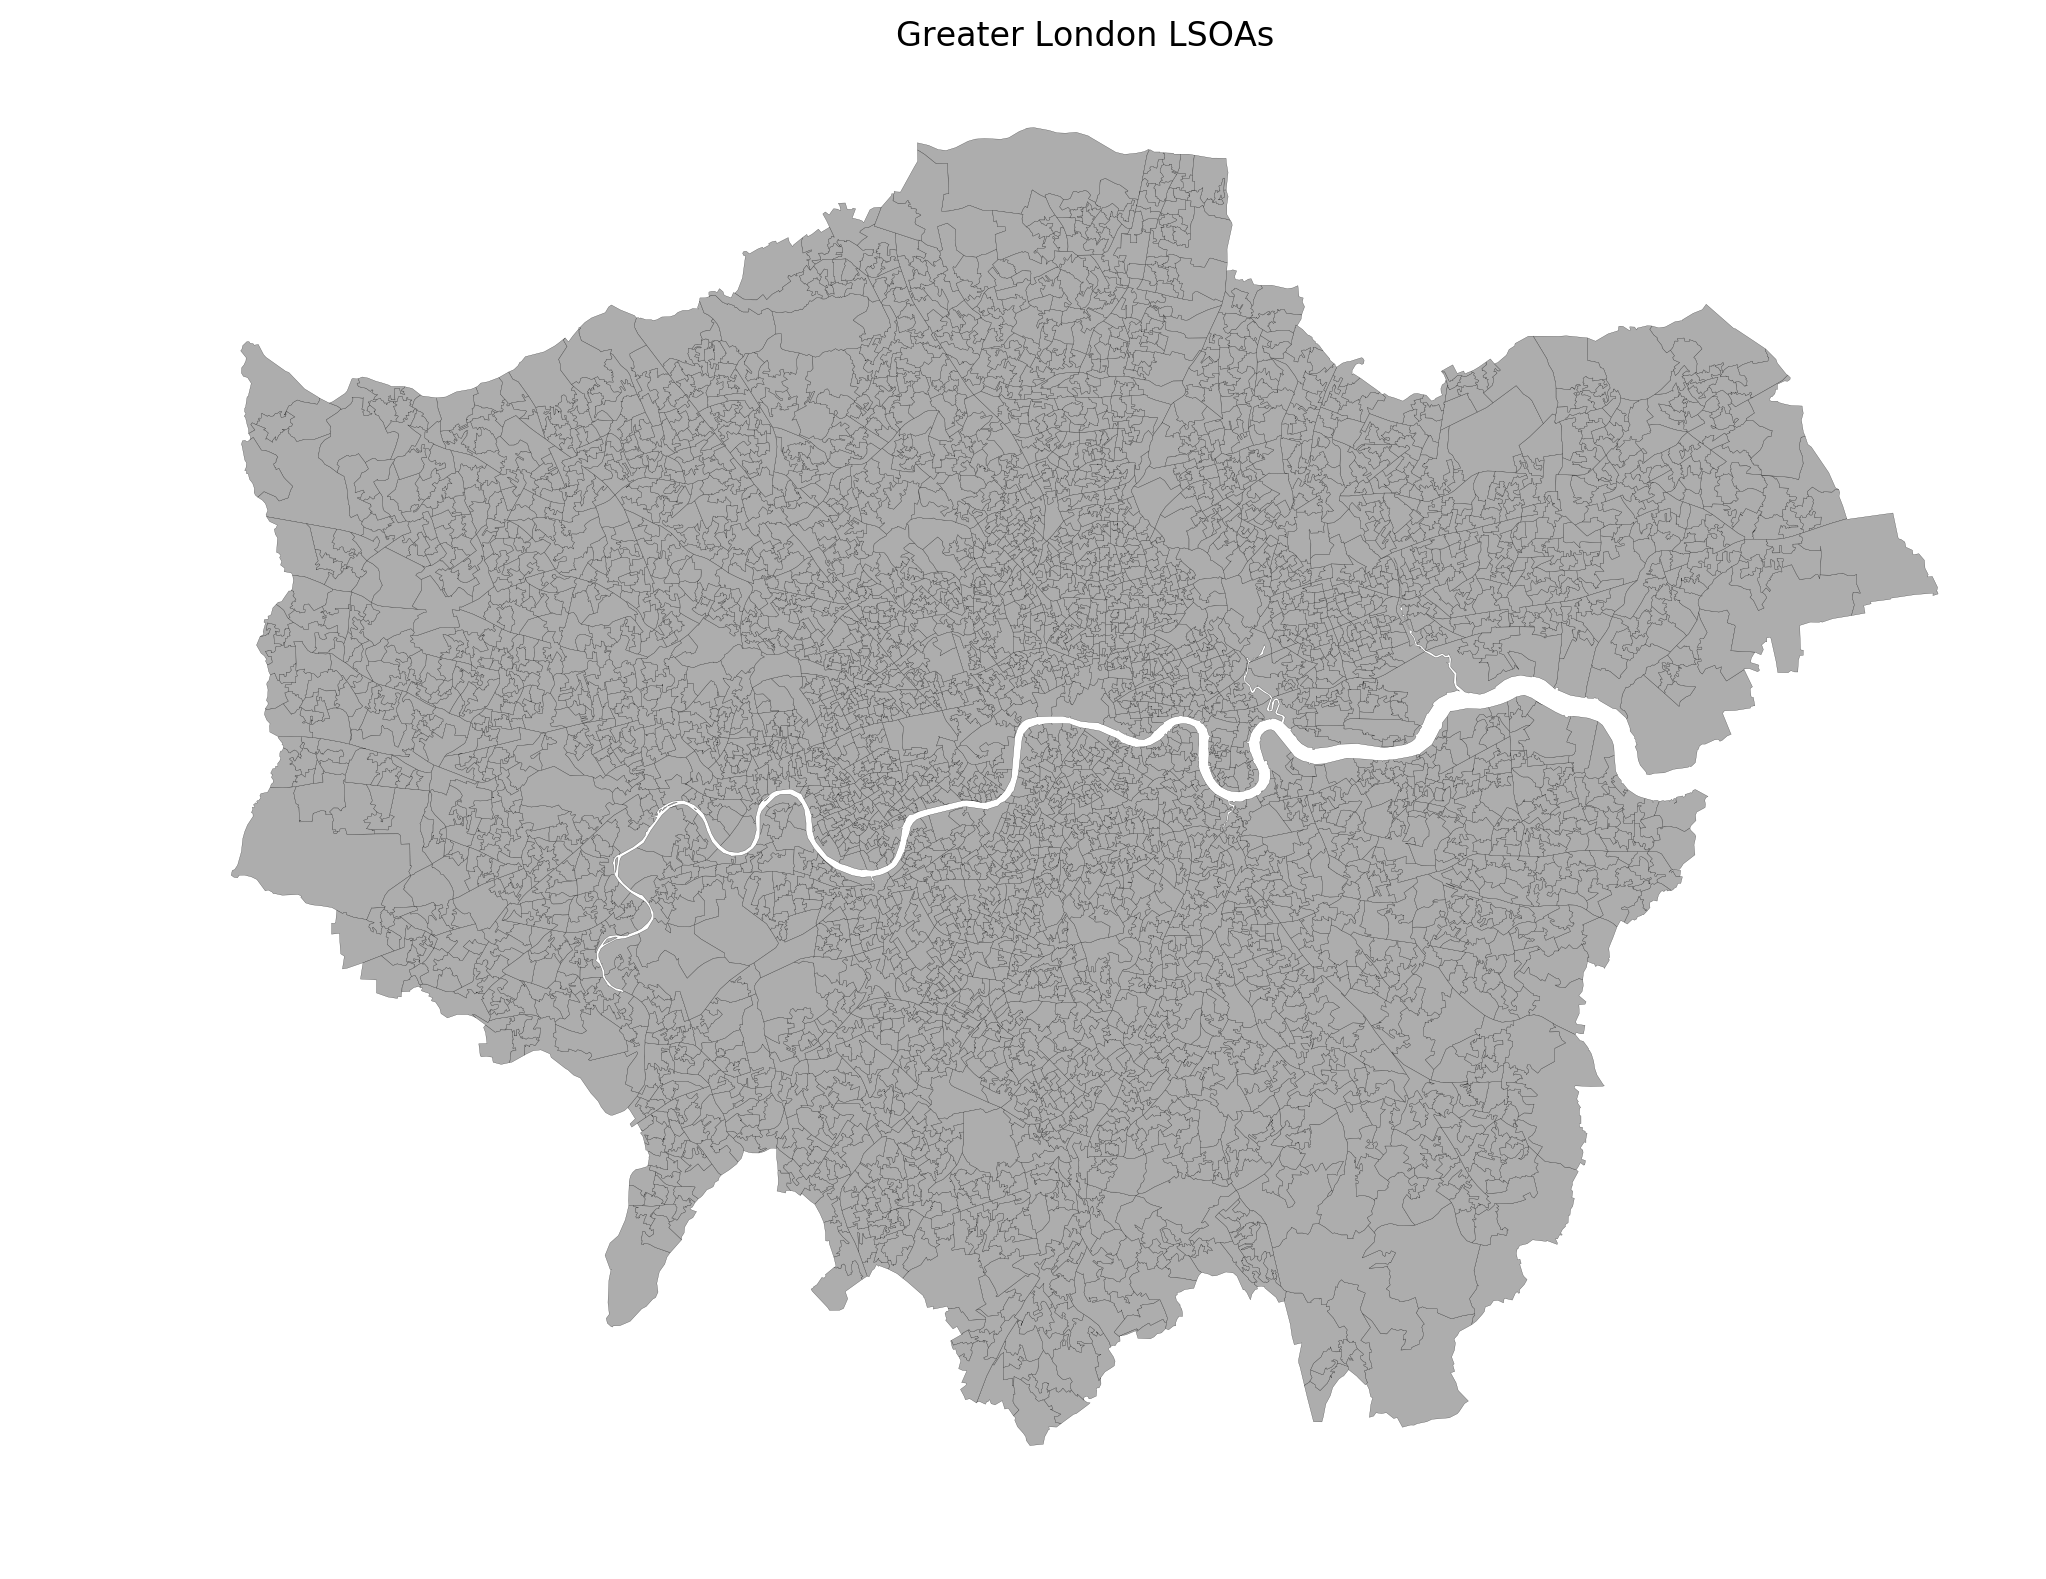

In [11]:
f, ax = plt.subplots(1, figsize=(12., 8.), dpi=200, subplot_kw=dict(aspect='equal'))
ax.axis('off')
lsoas_london.plot(ax=ax, linewidth=0.1, facecolor='#999999', edgecolor='#111111', alpha=0.8)
plt.title('Greater London LSOAs')
plt.tight_layout()

In [3]:
#Reading 3circles data
FILE_NAME = "../../../Data/London_venue_info_v2.csv" 
USE_COLS = ['lat', 'lng', 'category']

#with pandas
df = pd.read_csv(FILE_NAME, delimiter=",", usecols=USE_COLS)
#to geopandas
places_london = gpd.GeoDataFrame(df.drop(['lat', 'lng'], axis=1),
                                 crs={'init': 'epsg:4326'},
                                 geometry=[Point(x, y) for x, y in zip(df.lng, df.lat)])
places_london.head()

category                                        geometry
0                Pubs   POINT (-0.1334339549238772 51.51759527965574)
1  Fish & Chips Shops  POINT (-0.06212838758232592 51.53586439687221)
2           Bus Lines   POINT (-0.1030677339855296 51.54342483205862)
3  Mobile Phone Shops                   POINT (-0.2215498 51.5091377)
4  French Restaurants                     POINT (-0.090007 51.436141)

In [4]:
#setting projection
lsoas_london = lsoas_london.to_crs({'proj': 'tmerc'})
places_london = places_london.to_crs({'proj': 'tmerc'})

['#D5E3D8', '#618A98', '#F9DA95', '#AE4B16', '#787064']


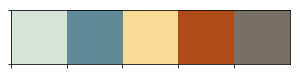

In [6]:
#palette
wes = pltt.wesanderson.Darjeeling2_5.hex_colors
palplot(wes)
print wes

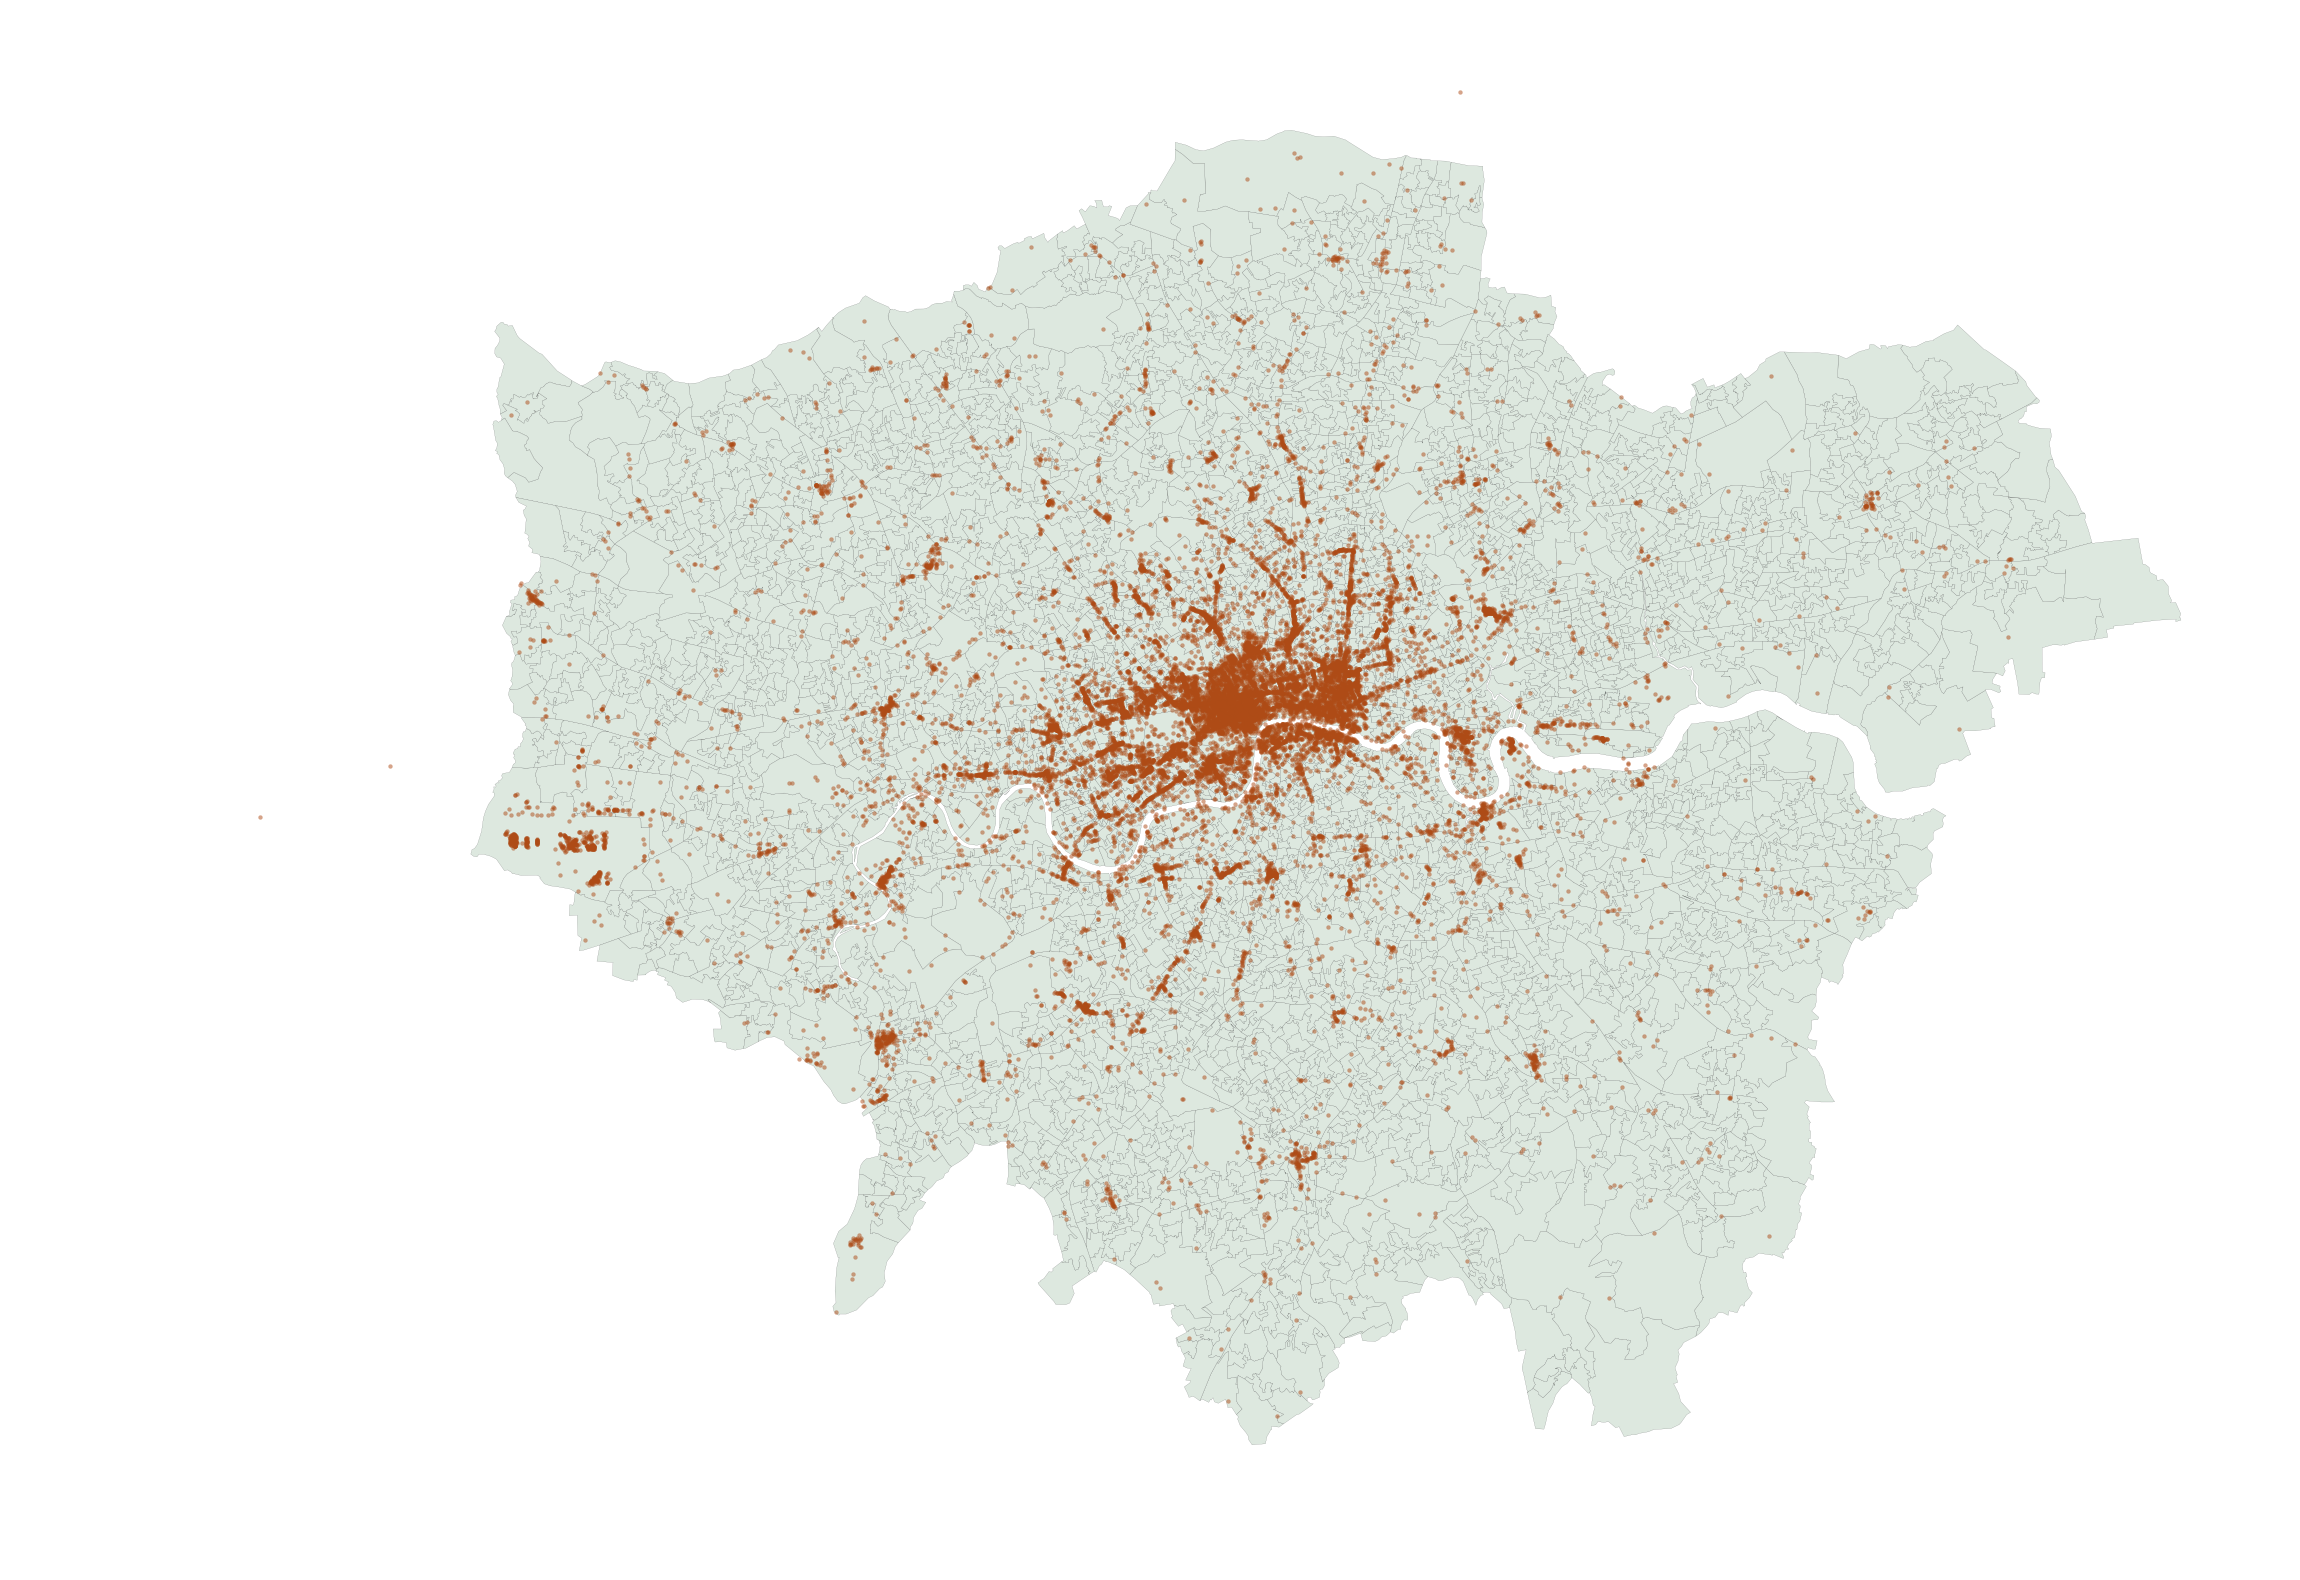

In [10]:
f, ax = plt.subplots(1, figsize=(12., 8.), dpi=200, subplot_kw=dict(aspect='equal'))
ax.axis('off')

lsoas_london.plot(ax=ax, linewidth=0.05, facecolor='#D5E3D8', edgecolor='#111111', alpha=0.8)
places_london.plot(ax=ax, linewidth=0.1, facecolor='#AE4B16', alpha=0.5, edgecolor='#AE4B16', markersize=2)

plt.tight_layout()

plt.savefig('../figures/london_LSOAs_plus_venues.png', dpi=200, transparent=True, tight_layout=True)

In [5]:
#Joining tables
jdf = gpd.sjoin(places_london, lsoas_london, how='right',op='within').reset_index()
jdf = jdf.drop(['index_right', 'index_left'], axis=1)
jdf.head()

category   LSOA11CD  \
0               Libraries  E01000001   
1                   Lakes  E01000001   
2           Cocktail Bars  E01000001   
3  Performing Arts Venues  E01000001   
4           Art Galleries  E01000001   

                                            geometry  
0  POLYGON ((-6640.876131843051 5710060.553200294...  
1  POLYGON ((-6640.876131843051 5710060.553200294...  
2  POLYGON ((-6640.876131843051 5710060.553200294...  
3  POLYGON ((-6640.876131843051 5710060.553200294...  
4  POLYGON ((-6640.876131843051 5710060.553200294...

## Counting venues

In [6]:
cat_count = jdf.groupby('LSOA11CD', as_index=False).agg({'category': 'size', 'geometry': 'first'})
cat_count = gpd.GeoDataFrame(cat_count)
#
cat_count['logcatcount'] = np.log10(cat_count['category'])
cat_count.head()

LSOA11CD  category                                           geometry  \
0  E01000001        37  POLYGON ((-6640.876131843051 5710060.553200294...   
1  E01000002        77  POLYGON ((-6005.346420705409 5709818.696488084...   
2  E01000003        10  POLYGON ((-6605.717354470359 5710246.601913924...   
3  E01000005        36  POLYGON ((-4972.16861708077 5708770.679791695,...   
4  E01000006         1  POLYGON ((6437.580467144002 5712008.123041059,...   

   logcatcount  
0     1.568202  
1     1.886491  
2     1.000000  
3     1.556303  
4     0.000000

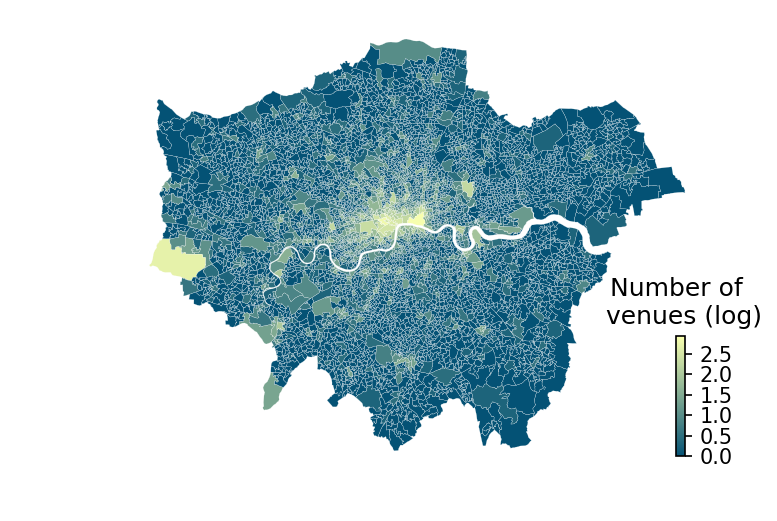

In [30]:
f, ax = plt.subplots(1, figsize=(6., 4.), dpi=150, subplot_kw=dict(aspect='equal'))
ax.axis('off')

#plotting
im = cat_count.plot(
    ax=ax,
    column='logcatcount', 
    k=7, 
    cmap= pltt.cartocolors.sequential.BluYl_2_r.mpl_colormap,
    alpha=1, 
    edgecolor='w', 
    linewidth=0.1, 
    legend=False, 
    antialiased=True)

#fixing colorbar
vmin = cat_count.logcatcount.min()
vmax = cat_count.logcatcount.max()
cax = f.add_axes([0.8, 0.15, 0.01, 0.2])
sm = plt.cm.ScalarMappable(cmap=pltt.cartocolors.sequential.BluYl_2_r.mpl_colormap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = f.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=10)

plt.title('Number of \n venues (log)', loc='center');
#plt.tight_layout()

plt.savefig('../figures/london_LSOAs_nvenues.png', dpi=150, transparent=True, tight_layout=True)

## Entropy of categories 

Not normalised by number of venues, so
$S([a,b,c])<S([a,b,c,d])$

In [45]:
from collections import Counter

def get_entropy(categories):
    sList = list(categories)
    alphabet = list(set(sList)) # list of unique symbols 
    #frequencies of symbols 
    freqList = Counter(sList).values()
    #normalising frequencies
    freqList = [1.*f/len(sList) for f in freqList]
    ent = 0.0
    for f in freqList:
        ent = ent + f*np.log(f)
    if ent!= 0:
        ent = -ent
    return ent

In [46]:
entropies_df = pd.DataFrame(columns=['entropy','norm_entropy','LSOA11CD','geometry'])

for lsoa in jdf['LSOA11CD'].unique():
    categories = jdf[jdf['LSOA11CD']==lsoa].category.values
    #computing entropy
    en = get_entropy(categories)
    #normalising by number of venues in the lsoa
    norm_en = en/len(categories)
    entropies_df = entropies_df.append({'entropy':en, 'norm_entropy':norm_en, 'LSOA11CD':lsoa,
                                        'geometry':jdf[jdf['LSOA11CD']==lsoa].head(1)['geometry'].values[0]},
                                        ignore_index=True)
#converting to gdf
entropies_gdf = gpd.GeoDataFrame(entropies_df)
entropies_gdf.head()

entropy  norm_entropy   LSOA11CD  \
0  2.945688      0.079613  E01000001   
1  3.555698      0.046178  E01000002   
2  2.302585      0.230259  E01000003   
3  2.775345      0.077093  E01000005   
4  1.386294      0.346574  E01000007   

                                            geometry  
0  POLYGON ((-6640.876131843051 5710060.553200294...  
1  POLYGON ((-6005.346420705409 5709818.696488084...  
2  POLYGON ((-6605.717354470359 5710246.601913924...  
3  POLYGON ((-4972.16861708077 5708770.679791695,...  
4  POLYGON ((5506.549171801797 5712419.466031407,...

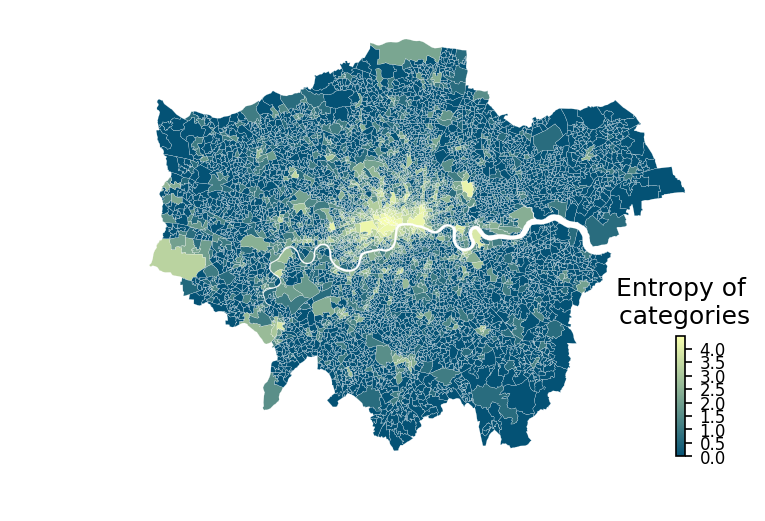

In [47]:
f, ax = plt.subplots(1, figsize=(6., 4.), dpi=150, subplot_kw=dict(aspect='equal'))
ax.axis('off')

#plotting
im = entropies_gdf.plot(
    ax=ax,
    column='entropy', 
    k=7, 
    cmap= pltt.cartocolors.sequential.BluYl_2_r.mpl_colormap,
    alpha=1, 
    edgecolor='w', 
    linewidth=0.1, 
    legend=False, 
    antialiased=True)

#fixing colorbar
vmin = entropies_gdf.entropy.min()
vmax = entropies_gdf.entropy.max()
cax = f.add_axes([0.8, 0.15, 0.01, 0.2])
sm = plt.cm.ScalarMappable(cmap=pltt.cartocolors.sequential.BluYl_2_r.mpl_colormap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))

sm._A = []
cbr = f.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=8)

plt.title('Entropy of\n categories', loc='center');
#plt.tight_layout()

plt.savefig('../figures/london_LSOAs_entropy.png', dpi=150, transparent=True, tight_layout=True)

In [48]:
x_count=[]
y_en=[]

for lsoa in jdf['LSOA11CD'].unique():
    categories = jdf[jdf['LSOA11CD']==lsoa].category.values
    #computing entropy
    en = get_entropy(categories)
    
    x_count.append(len(categories))
    y_en.append(en)

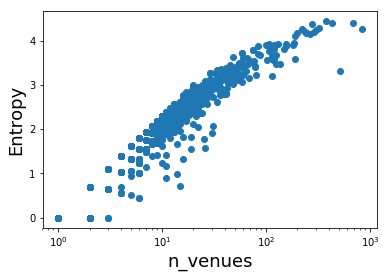

In [64]:
plt.scatter(x_count,y_en)
plt.xscale('log')
plt.xlabel('n_venues', size=18)
plt.ylabel('Entropy', size=18);

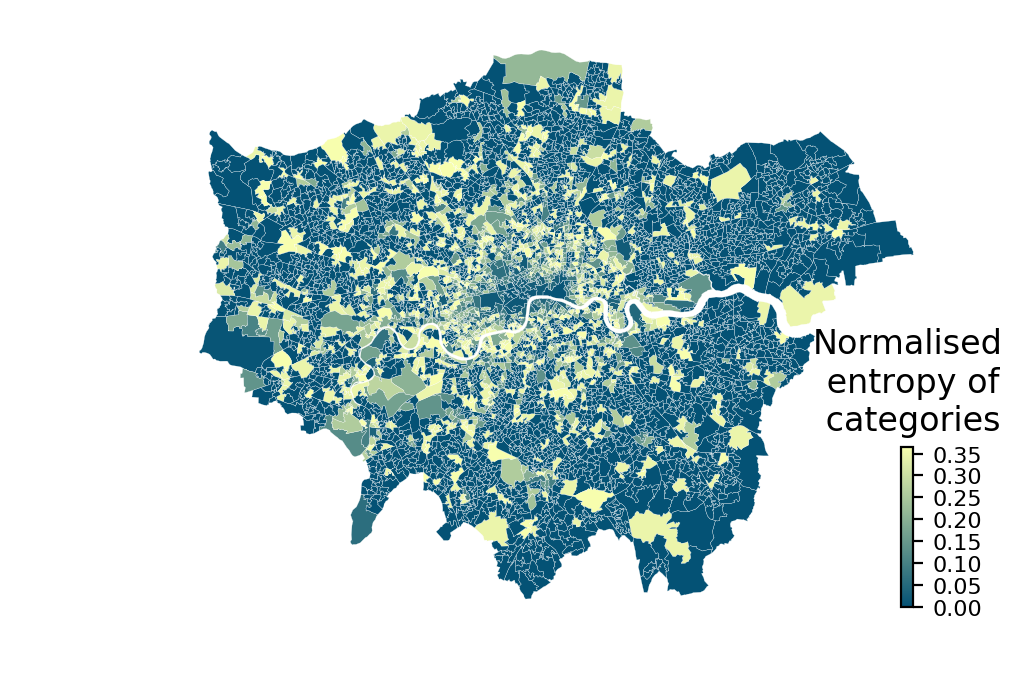

In [44]:
f, ax = plt.subplots(1, figsize=(6., 4.), dpi=200, subplot_kw=dict(aspect='equal'))
ax.axis('off')

#plotting
im = entropies_gdf.plot(
    ax=ax,
    column='norm_entropy', 
    k=7, 
    cmap= pltt.cartocolors.sequential.BluYl_2_r.mpl_colormap,
    alpha=1, 
    edgecolor='w', 
    linewidth=0.1, 
    legend=False, 
    antialiased=True)

#fixing colorbar
vmin = entropies_gdf.norm_entropy.min()
vmax = entropies_gdf.norm_entropy.max()
cax = f.add_axes([0.8, 0.15, 0.01, 0.2])
sm = plt.cm.ScalarMappable(cmap=pltt.cartocolors.sequential.BluYl_2_r.mpl_colormap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))

sm._A = []
cbr = f.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=8)

plt.title('Normalised\n entropy of\n categories', loc='center');
#plt.tight_layout()

plt.savefig('../figures/london_LSOAs_norm_entropy.png', dpi=150, transparent=True, tight_layout=True)

In [66]:
x_count=[]
y_norm_en=[]

for lsoa in jdf['LSOA11CD'].unique():
    categories = jdf[jdf['LSOA11CD']==lsoa].category.values
    #retrieving norm entropy
    norm_en = entropies_gdf[entropies_gdf['LSOA11CD']==lsoa]['norm_entropy'].values[0]
    
    x_count.append(len(categories))
    y_norm_en.append(norm_en)

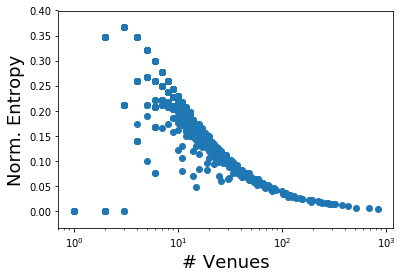

In [72]:
plt.scatter(x_count,y_norm_en)
plt.xlabel('# Venues', size=18)
plt.ylabel('Norm. Entropy', size=18);
plt.xscale('log');

# Comparing venues counter with Natalia's dataset

In [7]:
full_df = pd.read_csv('../../London_Data/Natalias_dataset_LSOA_venues_count.csv', index_col=0)

#Adding the log of the number of venues
full_df['logcount'] = np.log(full_df['count'])
full_df.head()

LSOA.Code  count  logcount
0  E01000001   2112  7.655391
1  E01000002   2913  7.976939
2  E01000003    156  5.049856
3  E01000005   1614  7.386471
4  E01000006    102  4.624973

In [8]:
merged = pd.merge(cat_count, full_df, left_on='LSOA11CD', right_on='LSOA.Code')
merged['perc_count']=(np.exp(merged['logcatcount'])/merged['count'])
merged.head()

LSOA11CD  category                                           geometry  \
0  E01000001        37  POLYGON ((-6640.876131843051 5710060.553200294...   
1  E01000002        77  POLYGON ((-6005.346420705409 5709818.696488084...   
2  E01000003        10  POLYGON ((-6605.717354470359 5710246.601913924...   
3  E01000005        36  POLYGON ((-4972.16861708077 5708770.679791695,...   
4  E01000006         1  POLYGON ((6437.580467144002 5712008.123041059,...   

   logcatcount  LSOA.Code  count  logcount  perc_count  
0     1.568202  E01000001   2112  7.655391    0.002272  
1     1.886491  E01000002   2913  7.976939    0.002264  
2     1.000000  E01000003    156  5.049856    0.017425  
3     1.556303  E01000005   1614  7.386471    0.002938  
4     0.000000  E01000006    102  4.624973    0.009804

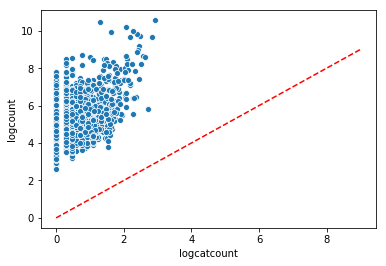

In [30]:
sns.scatterplot(y='logcount', x='logcatcount', data=merged)
plt.plot(range(10),range(10),'r--' )
#plt.xlim(-1,10)
#plt.ylim(-1,10)

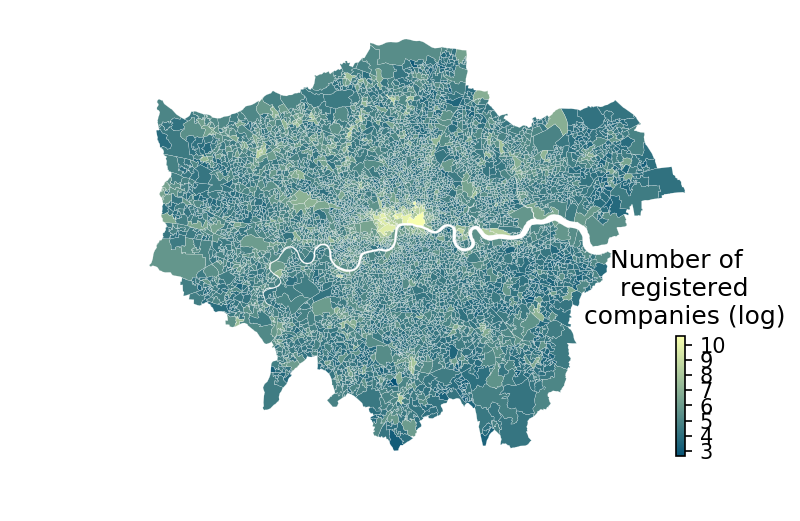

In [9]:
f, ax = plt.subplots(1, figsize=(6., 4.), dpi=150, subplot_kw=dict(aspect='equal'))
ax.axis('off')

#plotting
im = merged.plot(
    ax=ax,
    column='logcount', 
    k=7, 
    cmap= pltt.cartocolors.sequential.BluYl_2_r.mpl_colormap,
    alpha=1, 
    edgecolor='w', 
    linewidth=0.1, 
    legend=False, 
    antialiased=True)

#fixing colorbar
vmin = merged.logcount.min()
vmax = merged.logcount.max()
cax = f.add_axes([0.8, 0.15, 0.01, 0.2])
sm = plt.cm.ScalarMappable(cmap=pltt.cartocolors.sequential.BluYl_2_r.mpl_colormap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = f.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=10)

plt.title('Number of \n registered\n companies (log)', loc='center');
#plt.tight_layout()

plt.savefig('../figures/london_LSOAs_nregistered_companies.png', dpi=150, transparent=True, tight_layout=True)

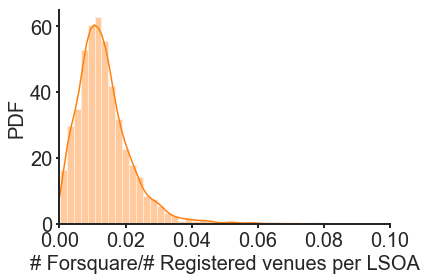

In [72]:
import seaborn as sns
#sns.set_style('white')
sns.set_style("ticks")

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['axes.linewidth'] = 2

fig = plt.figure()

ax = plt.subplot(1,1,1)

sns.distplot(merged['perc_count'], color = u'#ff7f0e')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel(r'# Forsquare/# Registered venues per LSOA', size=20)
ax.set_ylabel(r'PDF', size=20)
ax.set_xlim(0,0.100)
ax.set_ylim(0,65)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)  

plt.tight_layout()

plt.savefig('../figures/london_LSOAs_forsquare_over_registered_venues.pdf', dpi=150, transparent=True, tight_layout=True)